# Урок 6. Градиентный бустинг

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

**Задание**


*Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams.update({'font.size': 14})

Используем один из "игрушечных" датасетов из той же библиотеки.

In [4]:
from sklearn.datasets import load_diabetes

In [5]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [7]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [8]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [9]:
def bias(y, z):
    return - 2 * (z - y)

Реализуем функцию обучения градиентного бустинга.

In [10]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [11]:
# Число деревьев в ансамбле
n_trees = 50
# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

In [12]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(mean_squared_error(y_train, train_prediction))}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(mean_squared_error(y_test, test_prediction))}')

In [13]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 884
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3449


In [14]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

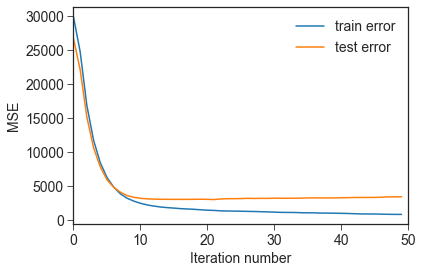

In [15]:
get_error_plot(n_trees, train_errors, test_errors)

Стохастический градиентный бустинг

In [16]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, 
            frac=1.0):
    """
    Функция обучения стохастического градиентного бустинга 
    """
    trees = []
    # Запись ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    for i in range(n_trees):
        # формируем обучающую и тестовую подвыборку 
        indexes_all = np.random.permutation(X_train.shape[0])
        indexes = indexes_all[:int(X_train.shape[0] * frac)]
        X_train_selected, y_train_selected = X_train[indexes], y_train[indexes]
        
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train_selected, y_train_selected)
            train_errors.append(mean_squared_error(y_train_selected, 
                                                   gb_predict(X_train_selected, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train_selected, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_selected, bias(y_train_selected, z_train))
            train_errors.append(mean_squared_error(y_train_selected, 
                                                   gb_predict(X_train_selected, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [17]:
# Число деревьев в ансамбле
n_trees = 50
# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees
# Максимальная глубина деревьев
max_depth = 3
# Шаг
eta = 0.1
frac = 0.5

trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, 
                                           X_train, X_test, 
                                           y_train, y_test, 
                                           coefs, eta,
                                           frac)

In [18]:
print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {round(train_errors_sgb[-1])}')

print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {round(test_errors_sgb[-1])}')

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1149
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 3138


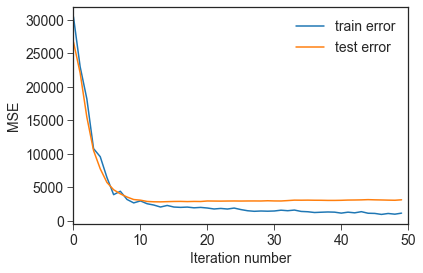

In [19]:
get_error_plot(n_trees, train_errors_sgb, test_errors_sgb)

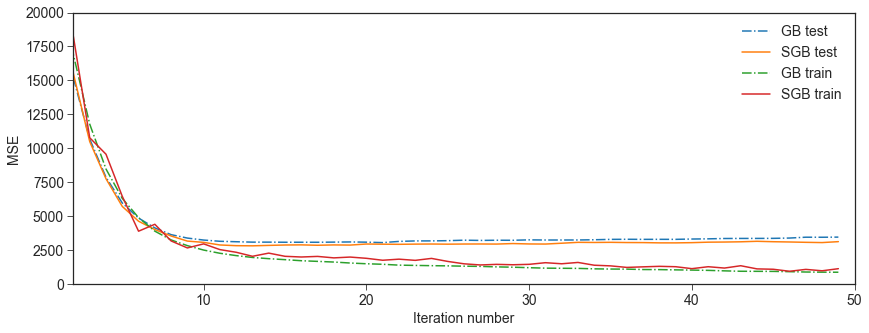

In [20]:
plt.figure(figsize=(14,5))
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(2, n_trees)
plt.ylim(0, 20000)
plt.plot(list(range(n_trees)), test_errors, '-.', label='GB test')
plt.plot(list(range(n_trees)), test_errors_sgb, label='SGB test')
plt.plot(list(range(n_trees)), train_errors, '-.', label='GB train')
plt.plot(list(range(n_trees)), train_errors_sgb, '-', label='SGB train')
plt.legend(loc='upper right');

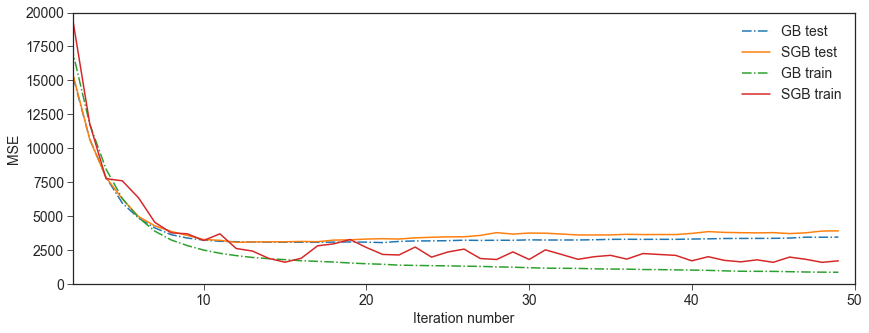

In [21]:
frac = 0.2

trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, 
                                           X_train, X_test, 
                                           y_train, y_test, 
                                           coefs, eta,
                                           frac)
plt.figure(figsize=(14,5))
plt.xlabel('Iteration number')
plt.ylabel('MSE')
plt.xlim(2, n_trees)
plt.ylim(0, 20000)
plt.plot(list(range(n_trees)), test_errors, '-.', label='GB test')
plt.plot(list(range(n_trees)), test_errors_sgb, label='SGB test')
plt.plot(list(range(n_trees)), train_errors, '-.', label='GB train')
plt.plot(list(range(n_trees)), train_errors_sgb, '-', label='SGB train')
plt.legend(loc='upper right');